In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('jamb_exam_results.csv')

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
# drop student id
df = df.drop('student_id', axis=1)

# fill null with 0
df = df.fillna(0)

In [5]:
df.isnull().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   jamb_score                    5000 non-null   int64  
 1   study_hours_per_week          5000 non-null   int64  
 2   attendance_rate               5000 non-null   int64  
 3   teacher_quality               5000 non-null   int64  
 4   distance_to_school            5000 non-null   float64
 5   school_type                   5000 non-null   object 
 6   school_location               5000 non-null   object 
 7   extra_tutorials               5000 non-null   object 
 8   access_to_learning_materials  5000 non-null   object 
 9   parent_involvement            5000 non-null   object 
 10  it_knowledge                  5000 non-null   object 
 11  age                           5000 non-null   int64  
 12  gender                        5000 non-null   object 
 13  soc

In [7]:
df.describe()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,age,assignments_completed
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,174.074600,19.521200,84.235200,2.521400,10.005460,18.445800,1.804600
std,47.616477,9.634569,9.485688,0.985564,4.820221,2.301504,0.992076
min,100.000000,0.000000,50.000000,1.000000,0.000000,15.000000,1.000000
25%,135.000000,13.000000,78.000000,2.000000,6.600000,16.000000,1.000000
50%,170.000000,19.000000,84.000000,2.000000,10.000000,18.000000,1.000000
75%,209.000000,26.000000,91.000000,3.000000,13.400000,20.000000,2.000000
max,367.000000,40.000000,100.000000,5.000000,20.000000,22.000000,5.000000


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['jamb_score'].values
y_val = df_val['jamb_score'].values
y_test = df_test['jamb_score'].values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [10]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [11]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [12]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- study_hours_per_week <= 18.50
|   |--- class: 118
|--- study_hours_per_week >  18.50
|   |--- class: 190



In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as rmse

In [14]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [15]:
y_pred = rf.predict(X_val)
np.sqrt(rmse(y_val, y_pred))

np.float64(42.13724207871227)

In [16]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    _rmse = np.sqrt(rmse(y_val, y_pred))

    scores.append((n, _rmse))

In [17]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

In [18]:
sns.set_style('darkgrid')

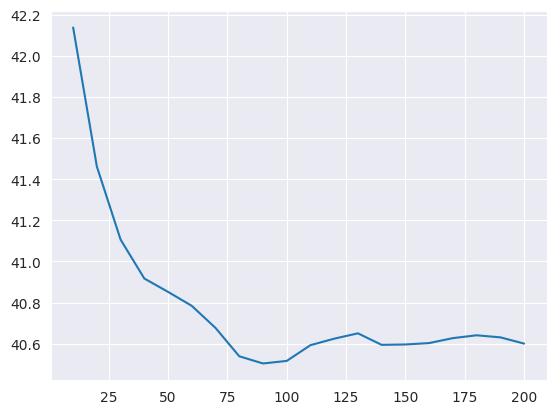

In [19]:
plt.plot(df_scores.n_estimators, df_scores.rmse);

In [20]:
max_depth = [10, 15, 20, 25]

In [21]:
scores = []

for d in max_depth:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, random_state=1, max_depth=d, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        _rmse = np.sqrt(rmse(y_val, y_pred))

        scores.append((d, n, _rmse))

In [22]:
df_scores = pd.DataFrame(scores, columns=['d', 'n_estimators', 'rmse'])

In [23]:
df_scores

,d,n_estimators,rmse
0,10,10,41.258349
1,10,20,40.880528
2,10,30,40.624956
3,10,40,40.270069
4,10,50,40.317006
...,...,...,...
75,25,160,40.600208
76,25,170,40.624371
77,25,180,40.638564
78,25,190,40.628661


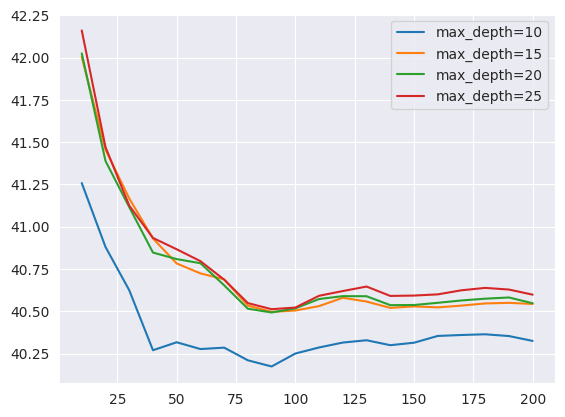

In [24]:
for d in max_depth:
    df_subset = df_scores[df_scores.d == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' %d)

plt.legend()

In [25]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [26]:
rf.feature_importances_

array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
       0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
       0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
       0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
       0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
       0.01070798, 0.01056268, 0.24835361, 0.08268222])

In [36]:
fn = dv.feature_names_
fi = rf.feature_importances_

fi_df = pd.DataFrame(zip(fn,fi), columns=['feature_name', 'feature_importance'])\
    .sort_values('feature_importance', ascending=False)\
    .reset_index(drop=True)

In [38]:
fi_df

,feature_name,feature_importance
0,study_hours_per_week,0.248354
1,attendance_rate,0.149729
2,distance_to_school,0.136486
3,teacher_quality,0.082682
4,age,0.069311
5,assignments_completed,0.031517
6,socioeconomic_status=High,0.025714
7,parent_involvement=High,0.022919
8,it_knowledge=High,0.017719
9,parent_education_level=Secondary,0.016957


In [39]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 56.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 46.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [40]:
import xgboost as xgb